In [94]:
import os
import pytesseract as pt
from PIL import Image as im
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.utils import np_utils
from sklearn.utils import shuffle
import cv2

In [4]:
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D ,Conv3D
from keras.layers import Input, Dense, Activation ,Flatten
from keras.layers import Reshape, Lambda 
from keras.layers.merge import add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image as ki
from keras.layers.convolutional_recurrent import ConvLSTM2D

In [291]:
def get_processed_images(image_dir):
    size = (224,224)
    normalized_image = []
    imgV = []
    print('images length',len(os.listdir(image_dir)))
    for pic in os.listdir(image_dir):
        try:
            img = im.open(image_dir+pic)
            img =img.resize(size,im.ANTIALIAS) 
            img_array = ki.img_to_array(img)

            v_min = img_array.min(axis=(0, 1), keepdims=True)
            v_max = img_array.max(axis=(0, 1), keepdims=True)
            img_array = (img_array - v_min)/(v_max - v_min)
            normalized_image.append(img_array)
            filterImage = filter(lambda x : x.shape[2]==3 ,normalized_image)
            imageData = np.array(list(filterImage))
        except:
            pass
    return imageData

    


In [293]:
from sklearn.model_selection import train_test_split
invoiceData = get_processed_images("purchase_order\\")
adharData= get_processed_images("adhar_card\\")

image_data = np.concatenate([invoiceData,adharData])

images length 489


C:\Users\PwC Hyd\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


images length 437


In [294]:
Y=np.zeros((len(adharData),)) # ALL THE ZEROES ARE NON INVOICE/ ADHAR DATA 
labels = np.ones((len(invoiceData),)) #ALL THE ONES ARE INVOICE DATA
print(len(invoiceData),len(adharData))
Y= np.concatenate([labels,Y])
Y = np_utils.to_categorical(Y, 2)

x,y = shuffle(image_data,Y, random_state=2)

X_train,X_test,y_train,y_test = train_test_split(x,y, train_size=0.88 ,test_size=0.12)
X_train.shape

222 367


(518, 224, 224, 3)

C:\Users\PwC Hyd\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


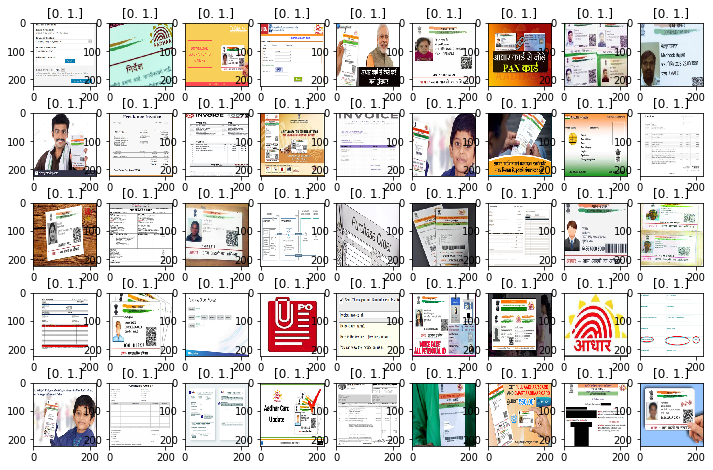

In [300]:

col_size= 9
row_size= 5
ig, ax = plt.subplots(row_size, col_size, figsize=(12,8))
i=0
for row in range(0,row_size):
    for col in range(0,col_size):
        ax[row][col].imshow(X_train[100-i])
        ax[row][col].set_title(Y[100-i])
        i+=1
        

In [297]:
#Training the classifier alone
image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')


In [308]:
last_layer = model.get_layer('block5_pool').output
from keras import regularizers

x= Flatten(name='flatten')(last_layer) 
x= Dense(128,activation='relu',name='fc1',kernel_regularizer=regularizers.l2(0.01))(x)
x= Dense(128,activation='relu',name='fc2')(x)
out = Dense(2, activation='softmax', name='output')(x)
custom_vgg_model = Model(image_input, out)
custom_vgg_model.summary()

for layer in custom_vgg_model.layers[:-3]:
    layer.trainable = False


custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [309]:
hist = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=9, verbose=1, validation_data=(X_test, y_test))


Train on 518 samples, validate on 71 samples
Epoch 1/9
518/518 [==============================] - 165s 318ms/step - loss: 5.6486 - acc: 0.5849 - val_loss: 1.5474 - val_acc: 0.5915
Epoch 2/9
518/518 [==============================] - 169s 326ms/step - loss: 1.0028 - acc: 0.8243 - val_loss: 0.5486 - val_acc: 0.8732
Epoch 3/9
518/518 [==============================] - 167s 322ms/step - loss: 0.5683 - acc: 0.8919 - val_loss: 1.6719 - val_acc: 0.5915
Epoch 4/9
518/518 [==============================] - 167s 322ms/step - loss: 0.4952 - acc: 0.8977 - val_loss: 0.3736 - val_acc: 0.9296
Epoch 5/9
518/518 [==============================] - 167s 322ms/step - loss: 0.5338 - acc: 0.8687 - val_loss: 0.1962 - val_acc: 0.9859
Epoch 6/9
518/518 [==============================] - 167s 323ms/step - loss: 0.5252 - acc: 0.8745 - val_loss: 0.4707 - val_acc: 0.8592
Epoch 7/9
518/518 [==============================] - 168s 323ms/step - loss: 0.3841 - acc: 0.9112 - val_loss: 0.3867 - val_acc: 0.8873
Epoch 8/9


array([[0., 1.]], dtype=float32)

In [325]:
size=(224,224)
img =  im.open('test_invoice.jpg')
img = img.resize(size,im.ANTIALIAS) 
image_to_predict  = ki.img_to_array(img)
image_to_predict = np.expand_dims(image_to_predict,axis=0)
image_to_predict = image_to_predict[:,:,:,:3]

In [326]:
print("Adhaar Card")  if custom_vgg_model.predict(image_to_predict).argmax()==0 else print("Invoice")

Invoice


In [217]:
def get_activations(activations,row_size,col_size,act_index):
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size): 
        for col in range(0,col_size):
            ax[row][col].imshow(activation[:, :,activation_index ], cmap='gray')
            activation_index += 1

In [322]:
inspect.getmembers(custom_vgg_model.layer[0])

AttributeError: 'Model' object has no attribute 'layer'

In [320]:
#get_weights [x, y, channel, nth convolutions layer ]
weight_conv2d_1 = model.layers[1].get_output_node()[0][:,:,0,:]
col_size = 6
row_size = 5
filter_index = 0
fig, ax = plt.subplots(row_size, col_size, figsize=(12,8))
for row in range(0,row_size):
    for col in range(0,col_size):
        ax[row][col].imshow(weight_conv2d_1[:,:,filter_index],cmap="gray")
        print(filter_index)
        
        filter_index += 1

AttributeError: 'Conv2D' object has no attribute 'get_output_node'

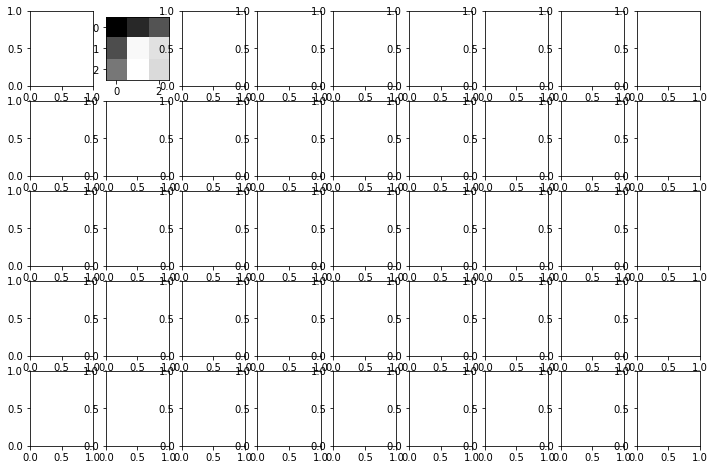

In [321]:
fig, ax = plt.subplots(row_size, col_size, figsize=(12,8))

ax[0][1].imshow(weight_conv2d_1[:,:,30],cmap="gray")

In [245]:
weight_conv2d_1[:,:,:]

array([[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02,
          3.54220927e-01, -8.65836963e-02,  2.29682952e-01,
          6.68324158e-02,  4.13383804e-02,  1.30267844e-01,
          3.29103470e-02,  9.61545706e-02, -9.22253206e-02,
         -1.55873314e-01,  5.22967987e-02, -8.32441747e-02,
          1.57287687e-01,  2.91195959e-02,  5.09483516e-02,
          1.90557480e-01, -4.37222868e-02,  3.61803114e-01,
          2.39028737e-01,  1.66671917e-01, -1.80467457e-01,
          4.40482050e-02,  9.59283710e-02, -4.38113064e-02,
         -1.88483506e-01, -4.39950228e-02, -1.89854458e-01,
         -2.33869821e-01,  1.28367439e-01, -1.10599749e-01,
          5.71336085e-03, -2.44796559e-01, -3.05302829e-01,
          6.09379970e-02, -3.28162521e-01,  1.71195298e-01,
          1.02654070e-01, -1.10636652e-01,  3.30129862e-01,
         -5.86972833e-02,  1.84787169e-01,  1.05085261e-02,
          1.06680267e-01, -1.30869240e-01, -3.62839460e-01,
          6.44080713e-02,  9.33597162e-0